In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import seaborn as sb
import matplotlib.pyplot as plt
import math
from scipy import optimize
import time
import sys
sys.path.append('/Users/alenastern/Documents/Spring2018/Machine_Learning/Machine_Learning_Public_Policy/hws/hw2')
import numpy as np
import explore as ex
import preprocess as pp
import getfeatures as gf
import evalmodel as em
import trainmodel as tm
from __future__ import division
from sklearn import preprocessing, cross_validation, svm, metrics, tree, decomposition, svm
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, OrthogonalMatchingPursuit, RandomizedLogisticRegression
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import ParameterGrid
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
import random
import pydot
from subprocess import check_call
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read in Data

In [2]:
outcomes = ex.read_data("data/outcomes.csv")
projects = ex.read_data("data/projects.csv")

In [4]:
projects['date_posted'] = pd.to_datetime(projects['date_posted'])

In [5]:
# Drop all variables besides fully_funded (label) from outcomes to avoid leakage

outcomes = outcomes[['projectid', 'fully_funded']]

In [6]:
#Subset project data for projects posted between 2011-2013

X = projects[(projects['date_posted'].dt.year >= 2011) & (projects['date_posted'].dt.year <= 2013)]

In [7]:
#Subset outcomes data for incldued projects

Y = outcomes[outcomes['projectid'].isin(X['projectid'])]

In [8]:
total_data = pd.merge(X, Y, on = 'projectid')

In [9]:
#Convert boolean variables from "t"/"f" to 1/0

colnames = ['fully_funded', 'school_charter', 'school_magnet', 'school_year_round', 'school_nlns', 'school_kipp', 'school_charter_ready_promise', 'teacher_teach_for_america', 'teacher_ny_teaching_fellow', 'eligible_double_your_impact_match', 'eligible_almost_home_match']
for col in colnames:
    
    mask = total_data[col] == 'f'
    column_name = col
    total_data.loc[mask, col] = 0
    
    mask = total_data[col] == 't'
    column_name = col
    total_data.loc[mask, col] = 1

In [10]:
#Drop variables that have information that will not be helpful for prediction, such as IDs and school geographic information

total_data = pp.drop_vars(total_data, ['teacher_acctid', 'schoolid', 
                          'school_ncesid', 'school_latitude', 'school_longitude', 'school_city', 'school_zip', 'school_district',
                          'school_county', 'projectid', 'school_state'])

# Explore Data

First, we explore the data to identify correlations and outliers. We see plotting the correlation matrix below that none of the variables seem to be strongly correlated with out outcome variable of fully_funded, noting that the categorical variables are not included in the table. 

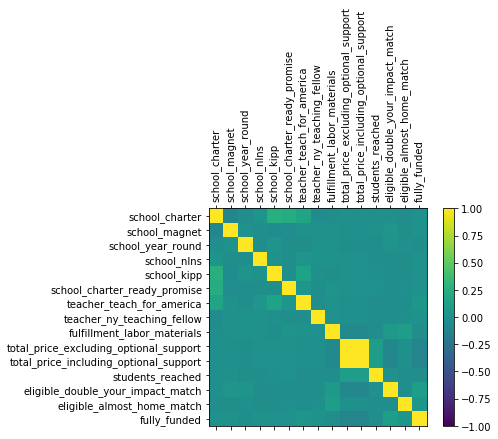

In [11]:
corr = ex.corr_table(total_data)
ex.plot_corr_matrix(corr)

In [12]:
# Create month variable

total_data['month'] = total_data['date_posted'].dt.month

In [14]:
avg_month = total_data.groupby([total_data['date_posted'].dt.year, total_data['date_posted'].dt.month]).mean()

In [15]:
avg_month['date_posted'] = avg_month.index

Time-Series Plots

Below, we produce plots of the outcome variable and the variables that appear to be most highly correlated with the outcome variable based upon the correlation plot above. While the overall trend line for the outcome variable and the match-eligibility variables seems fairly flat over time, the total price variables have a significant positive slope over time. 

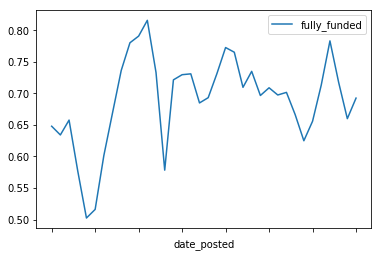

In [16]:
avg_month.plot(x='date_posted', y = ['fully_funded'], kind = 'line' )
plt.show()

/Users/alenastern/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


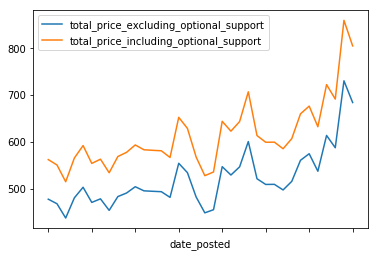

In [15]:
avg_month.plot(x='date_posted', y = ['total_price_excluding_optional_support', 'total_price_including_optional_support'], kind = 'line' )
plt.show()

/Users/alenastern/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


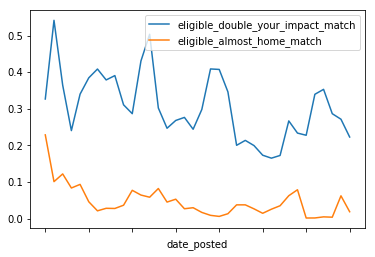

In [16]:
avg_month.plot(x='date_posted', y = ['eligible_double_your_impact_match', 'eligible_almost_home_match'], kind = 'line' )
plt.show()

Categorical Plots

We plot the distribution of the categorical variables below. We see that the majority of projects are located in urban, highest poverty schools, in elementary and pre-kindergarten classrooms. Technology and books are the most frequently requested supplies, and literacy is the most common primary subject and primary area.

In [18]:
categorical_vars = ['school_metro', 'teacher_prefix', 'primary_focus_subject', 'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area', 'resource_type', 'poverty_level', 'grade_level']
cat_data = total_data[categorical_vars]

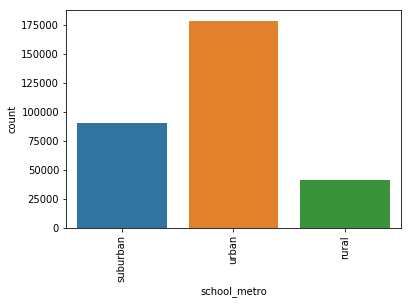

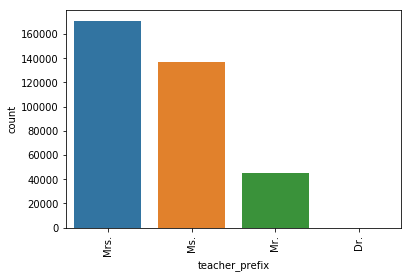

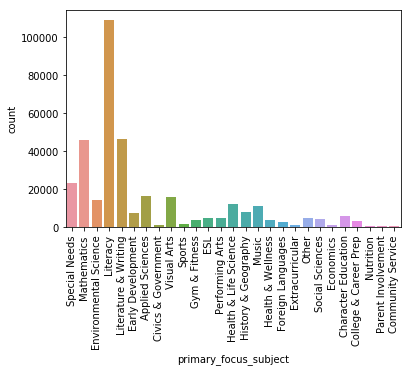

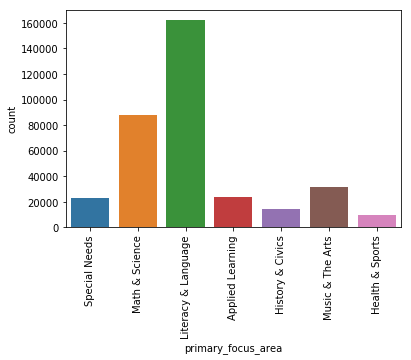

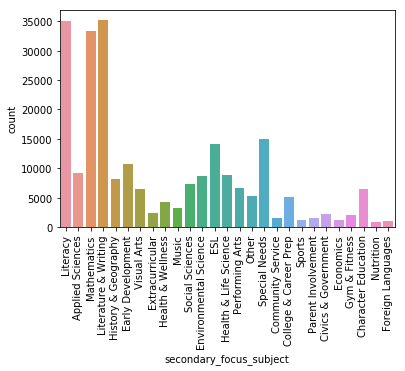

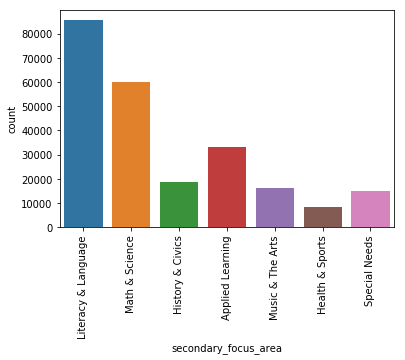

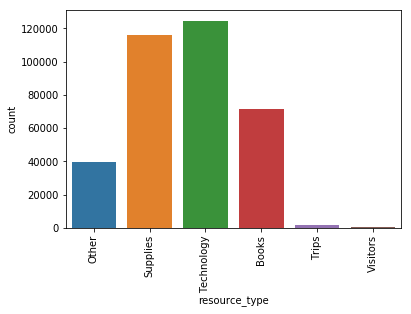

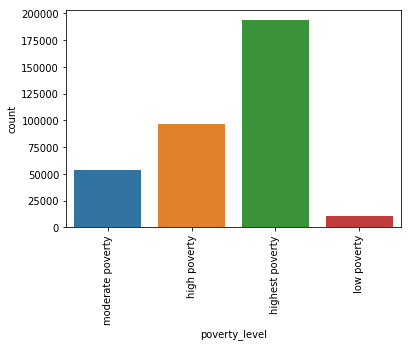

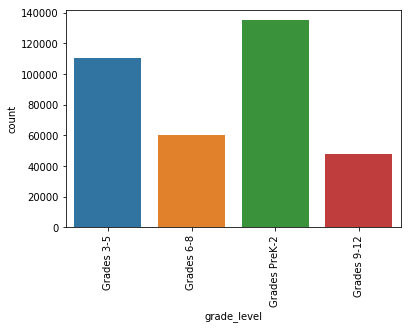

In [19]:
ex.cat_plot(cat_data, categorical_vars)

Plot Numeric Variables

We plot the numeric variables below. We see that fulfillment labor materials is either valued at 30 or 35. However, total price including/excluding optional support and students reached all have long tailed distributions with a significant number of large outliers. For that reason, we discretize all three of these variables prior to analysis to avoid the outliers skewing our findings.

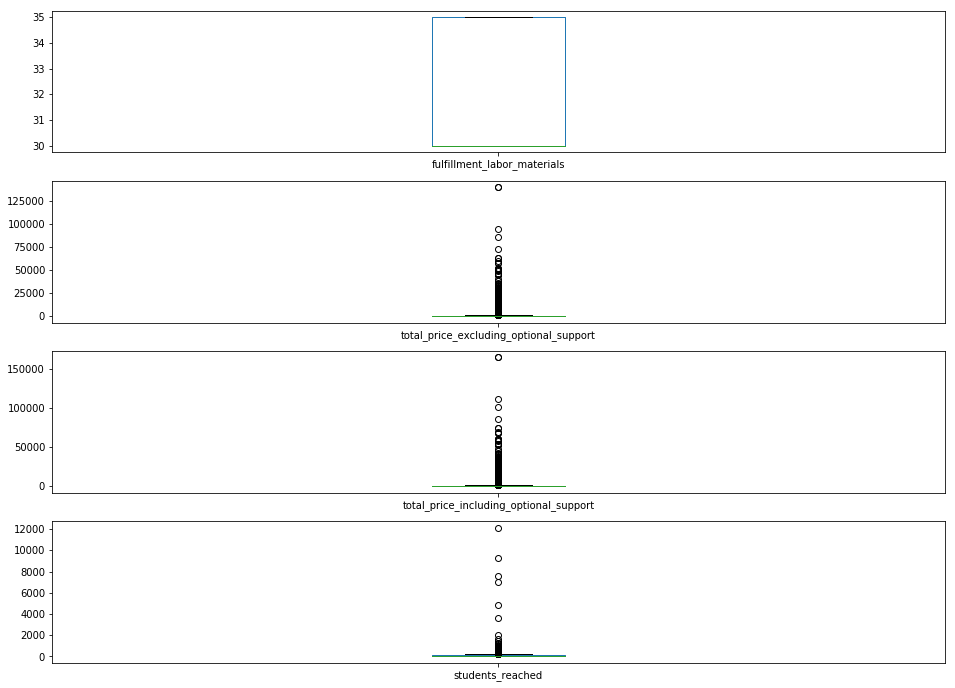

In [19]:
continuous_vars = ['fulfillment_labor_materials','total_price_excluding_optional_support', 
                   'total_price_including_optional_support', 'students_reached']

continuous_data = total_data[continuous_vars]

ex.outliers_plot(continuous_data)                                  
                                          

# Generate Features

In [20]:
# Generate dummy variables for all categorical variables

total_data = gf.cat_to_dummy(total_data, ['school_metro','month', 'primary_focus_subject', 'primary_focus_area', 'secondary_focus_subject','teacher_prefix',
                                          'secondary_focus_area', 'resource_type', 'poverty_level', 'grade_level', 'grade_level'])

In [21]:
# Generate discretized variables for students reached and total_price variables based on deciles

bin_sep = total_data.students_reached.quantile([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

data, bins = gf.discretize(total_data, "students_reached", num_bins = bin_sep)
bins

array([1.0000e+00, 1.8000e+01, 2.1000e+01, 2.4000e+01, 2.6000e+01,
       3.1000e+01, 5.0000e+01, 7.5000e+01, 1.2000e+02, 2.0000e+02,
       1.2143e+04])

In [22]:
bin_sep = total_data.total_price_including_optional_support.quantile([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

data, bins = gf.discretize(total_data, "total_price_including_optional_support", num_bins = bin_sep)
bins

array([4.3560000e+01, 2.2691000e+02, 3.0022000e+02, 3.7556000e+02,
       4.4096000e+02, 5.0267000e+02, 5.5211000e+02, 6.3887000e+02,
       8.0161000e+02, 9.9609000e+02, 1.6438284e+05])

In [23]:
bin_sep = total_data.total_price_excluding_optional_support.quantile([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

data, bins = gf.discretize(total_data, "total_price_excluding_optional_support", num_bins = bin_sep)
bins

array([3.7030000e+01, 1.9287000e+02, 2.5519000e+02, 3.1923000e+02,
       3.7482000e+02, 4.2727000e+02, 4.6929000e+02, 5.4304000e+02,
       6.8137000e+02, 8.4668000e+02, 1.3972541e+05])

In [24]:
#Drop variables that have been converted to dummy/discretized variables to avoid highly collinear variables

total_data = pp.drop_vars(total_data, ["students_reached","total_price_including_optional_support","school_suburban", 'primary_focus_subject', 'month', 'primary_focus_area', 'secondary_focus_area',
                          'secondary_focus_subject', 'resource_type', 'poverty_level', "total_price_excluding_optional_support", 'grade_level', 'grade_level', 'teacher_prefix', 'school_metro'])
 

In [25]:
#Show summary statistics for final set of features

ex.dist_table(total_data)

,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,teacher_teach_for_america,teacher_ny_teaching_fellow,fulfillment_labor_materials,eligible_double_your_impact_match,eligible_almost_home_match,fully_funded,school_metro_rural,school_metro_suburban,school_metro_urban,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,primary_focus_subject_Applied Sciences,primary_focus_subject_Character Education,primary_focus_subject_Civics & Government,primary_focus_subject_College & Career Prep,primary_focus_subject_Community Service,primary_focus_subject_ESL,primary_focus_subject_Early Development,primary_focus_subject_Economics,primary_focus_subject_Environmental Science,primary_focus_subject_Extracurricular,primary_focus_subject_Foreign Languages,primary_focus_subject_Gym & Fitness,primary_focus_subject_Health & Life Science,primary_focus_subject_Health & Wellness,primary_focus_subject_History & Geography,primary_focus_subject_Literacy,primary_focus_subject_Literature & Writing,primary_focus_subject_Mathematics,primary_focus_subject_Music,primary_focus_subject_Nutrition,primary_focus_subject_Other,primary_focus_subject_Parent Involvement,primary_focus_subject_Performing Arts,primary_focus_subject_Social Sciences,primary_focus_subject_Special Needs,primary_focus_subject_Sports,primary_focus_subject_Visual Arts,primary_focus_area_Applied Learning,primary_focus_area_Health & Sports,primary_focus_area_History & Civics,primary_focus_area_Literacy & Language,primary_focus_area_Math & Science,primary_focus_area_Music & The Arts,primary_focus_area_Special Needs,secondary_focus_subject_Applied Sciences,secondary_focus_subject_Character Education,secondary_focus_subject_Civics & Government,secondary_focus_subject_College & Career Prep,secondary_focus_subject_Community Service,secondary_focus_subject_ESL,secondary_focus_subject_Early Development,secondary_focus_subject_Economics,secondary_focus_subject_Environmental Science,secondary_focus_subject_Extracurricular,secondary_focus_subject_Foreign Languages,secondary_focus_subject_Gym & Fitness,secondary_focus_subject_Health & Life Science,secondary_focus_subject_Health & Wellness,secondary_focus_subject_History & Geography,secondary_focus_subject_Literacy,secondary_focus_subject_Literature & Writing,secondary_focus_subject_Mathematics,secondary_focus_subject_Music,secondary_focus_subject_Nutrition,secondary_focus_subject_Other,secondary_focus_subject_Parent Involvement,secondary_focus_subject_Performing Arts,secondary_focus_subject_Social Sciences,secondary_focus_subject_Special Needs,secondary_focus_subject_Sports,secondary_focus_subject_Visual Arts,teacher_prefix_Dr.,teacher_prefix_Mr.,teacher_prefix_Mrs.,teacher_prefix_Ms.,secondary_focus_area_Applied Learning,secondary_focus_area_Health & Sports,secondary_focus_area_History & Civics,secondary_focus_area_Literacy & Language,secondary_focus_area_Math & Science,secondary_focus_area_Music & The Arts,secondary_focus_area_Special Needs,resource_type_Books,resource_type_Other,resource_type_Supplies,resource_type_Technology,resource_type_Trips,resource_type_Visitors,poverty_level_high poverty,poverty_level_highest poverty,poverty_level_low poverty,poverty_level_moderate poverty,grade_level_Grades 3-5,grade_level_Grades 6-8,grade_level_Grades 9-12,grade_level_Grades PreK-2,grade_level_Grades 3-5,grade_level_Grades 6-8,grade_level_Grades 9-12,grade_level_Grades PreK-2,students_reached_bins,total_price_including_optional_support_bins,total_price_excluding_optional_support_bins
count,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.00

Show plots of each of the final features by the outcome label

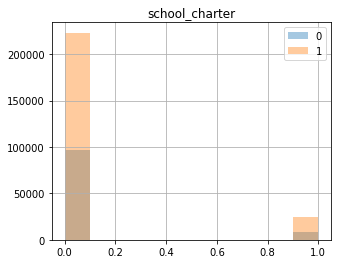

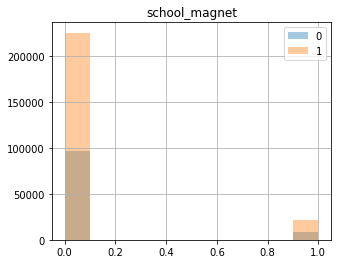

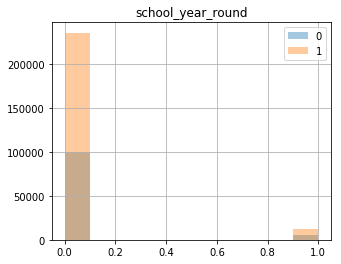

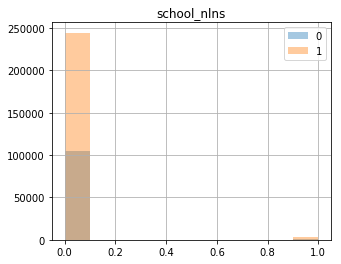

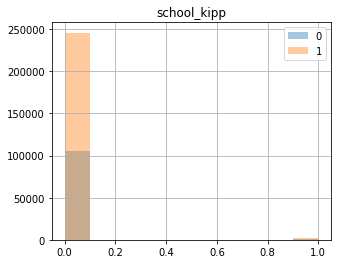

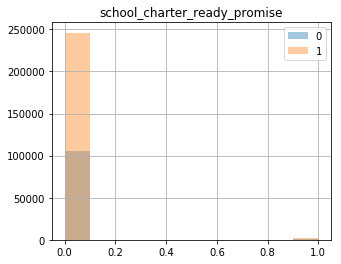

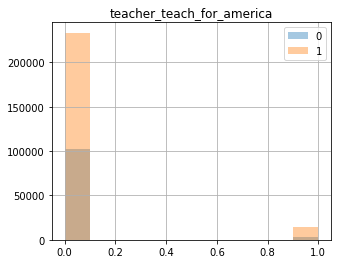

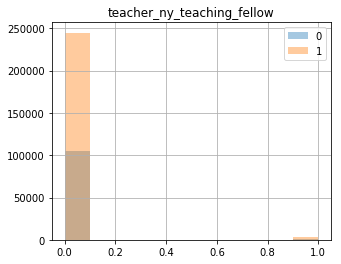

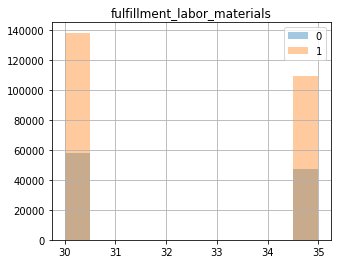

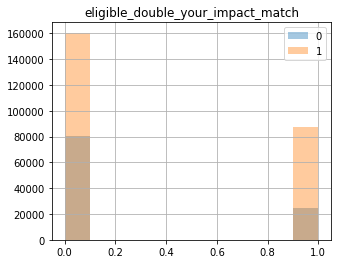

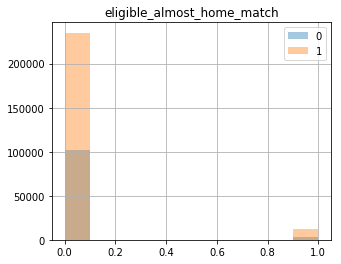

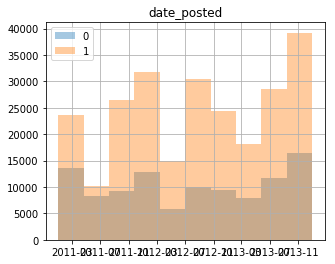

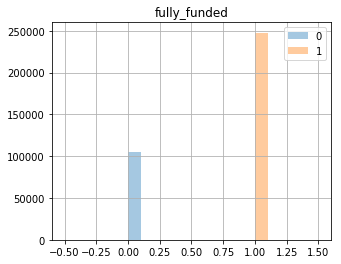

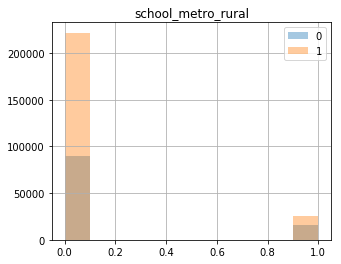

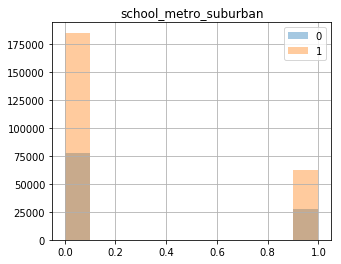

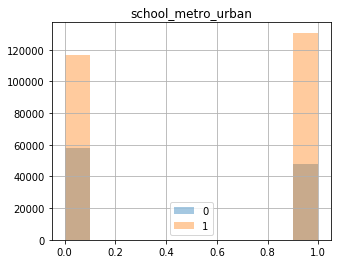

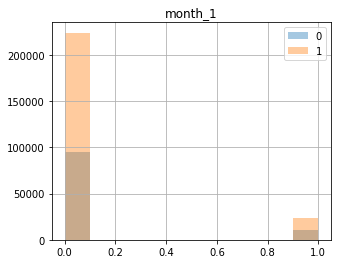

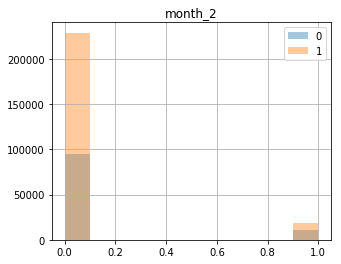

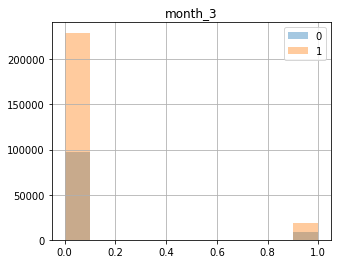

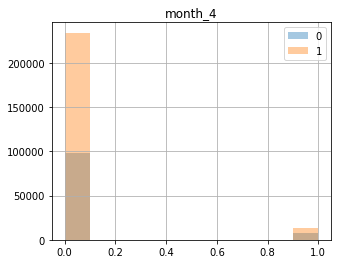

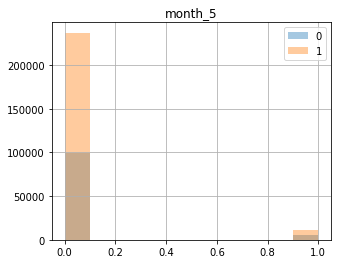

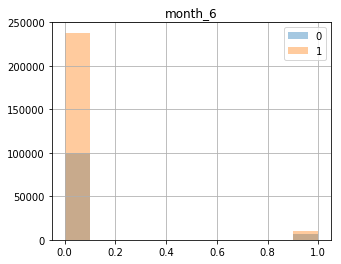

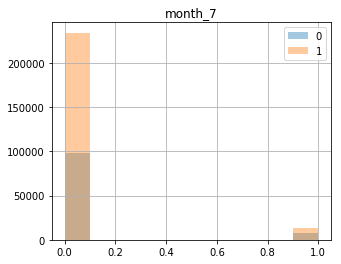

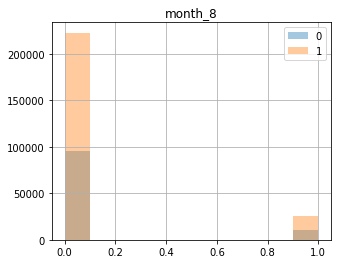

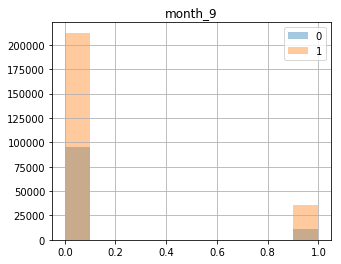

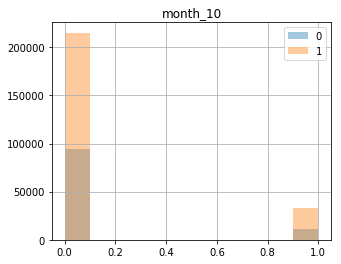

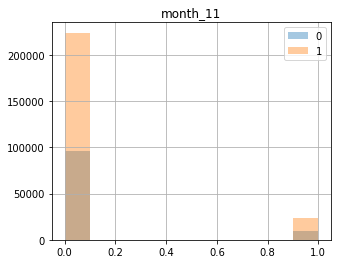

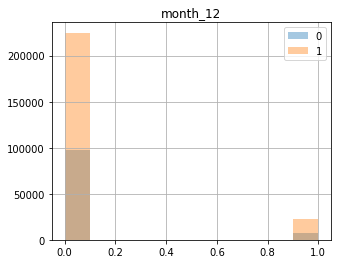

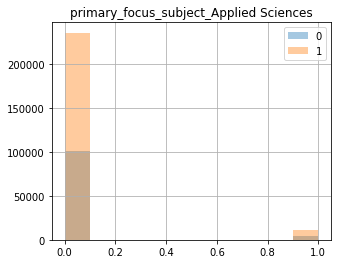

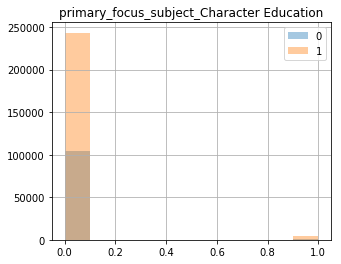

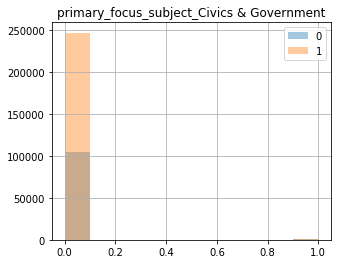

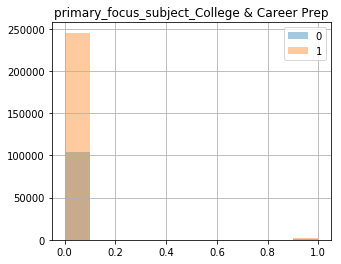

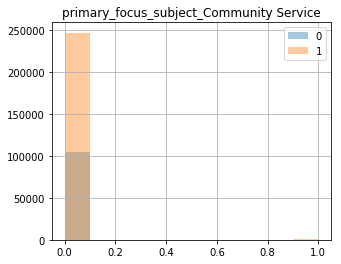

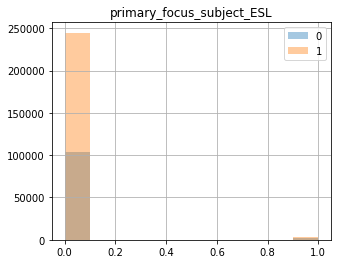

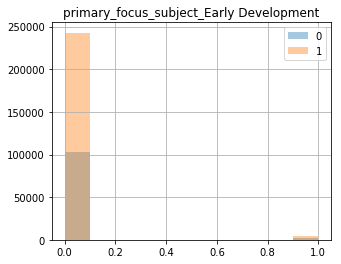

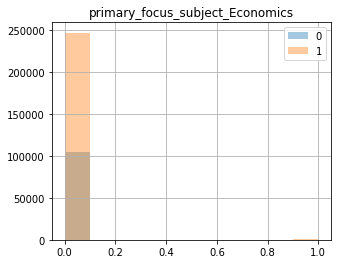

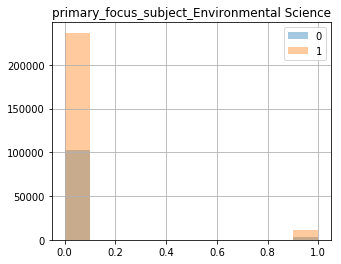

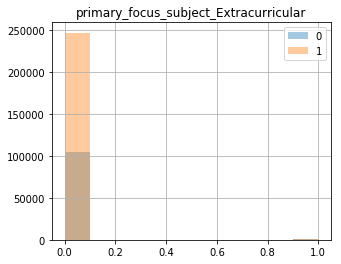

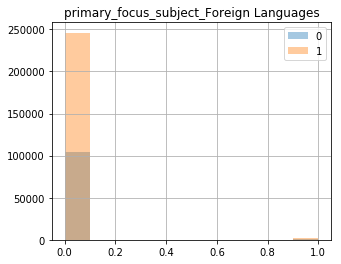

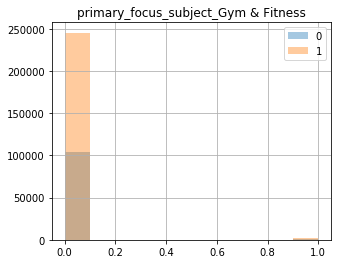

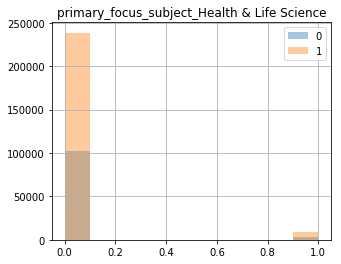

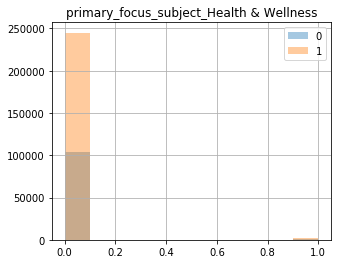

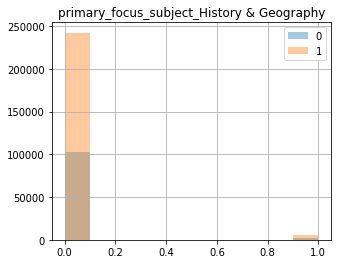

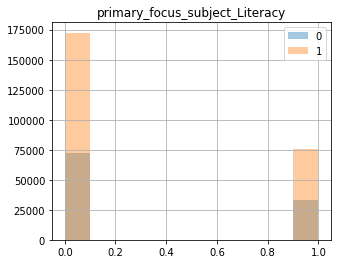

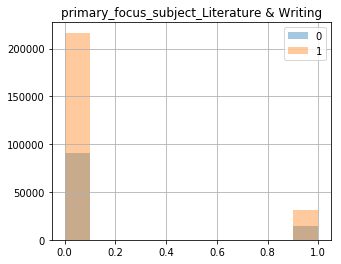

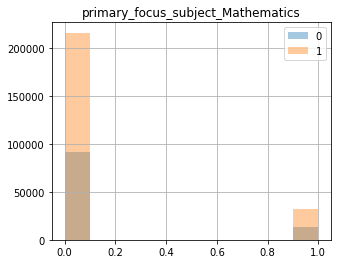

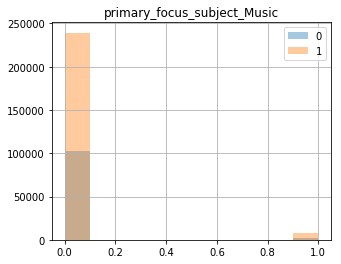

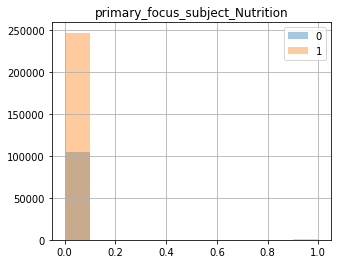

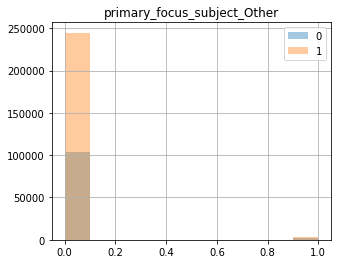

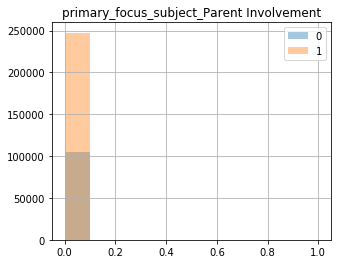

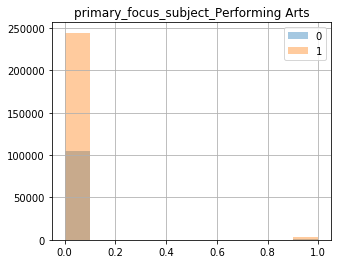

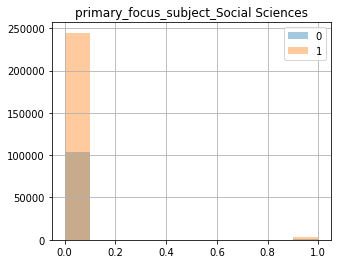

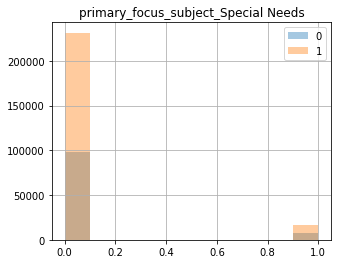

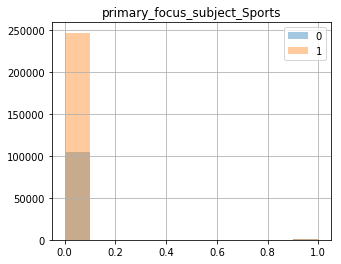

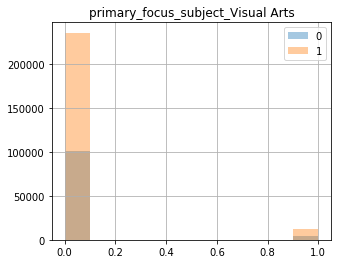

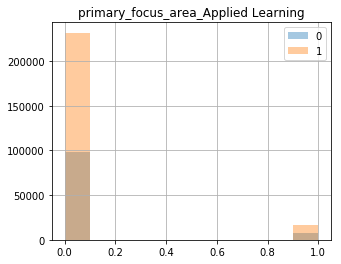

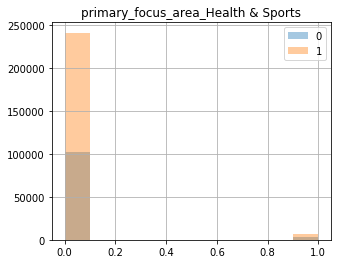

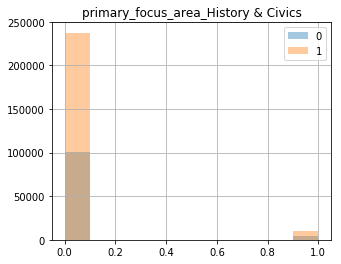

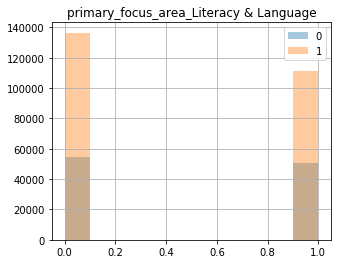

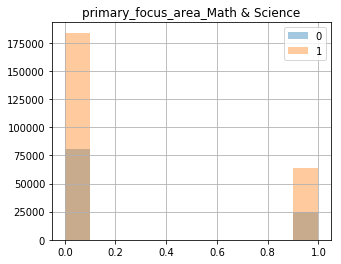

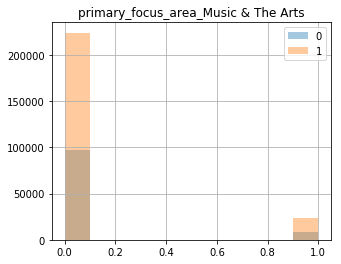

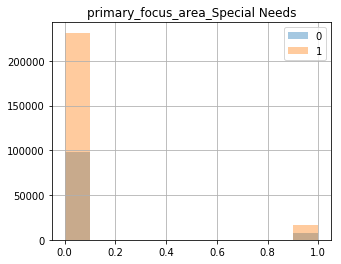

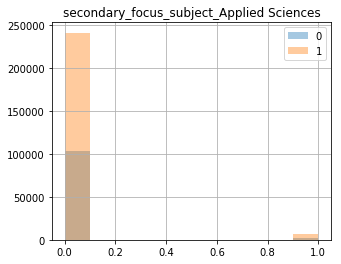

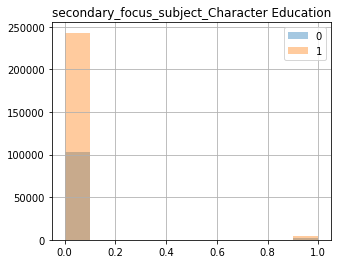

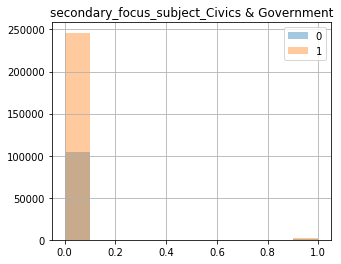

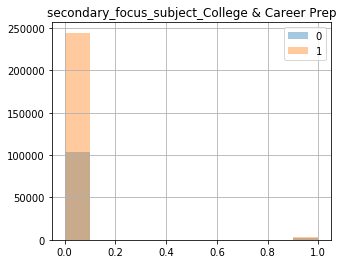

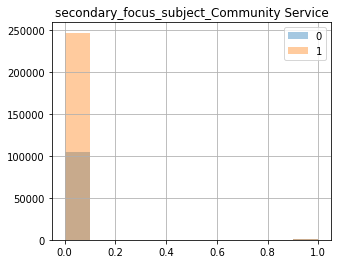

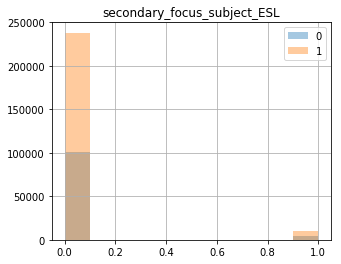

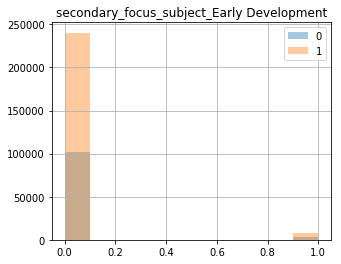

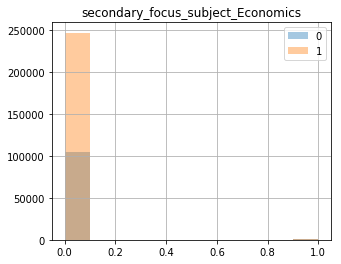

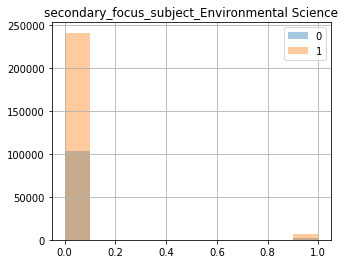

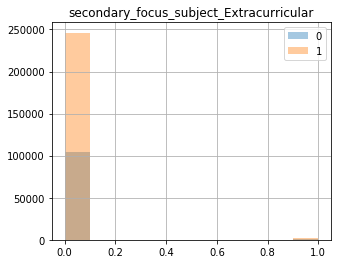

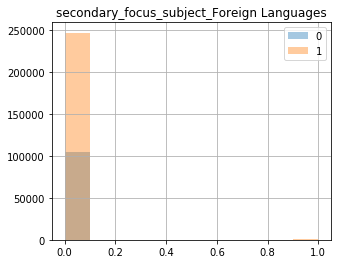

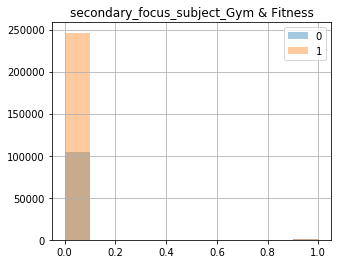

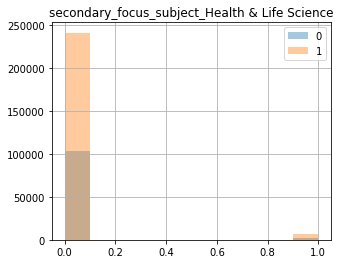

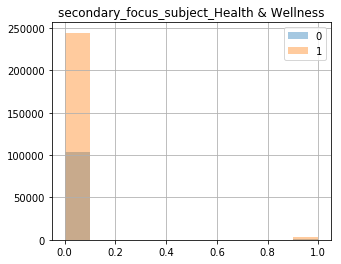

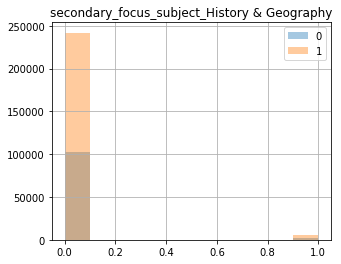

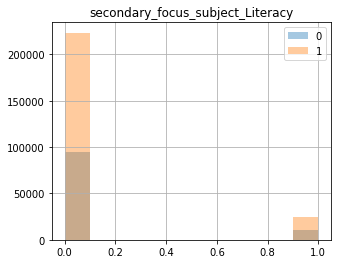

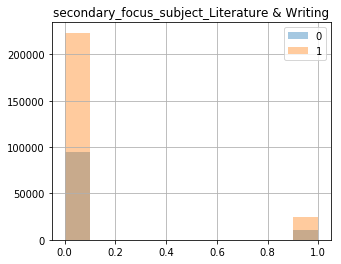

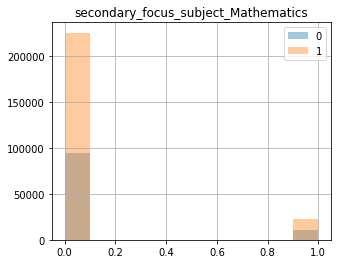

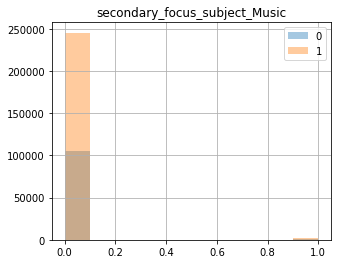

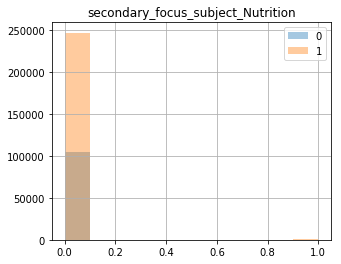

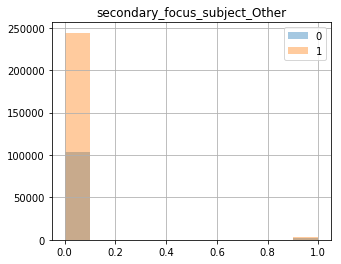

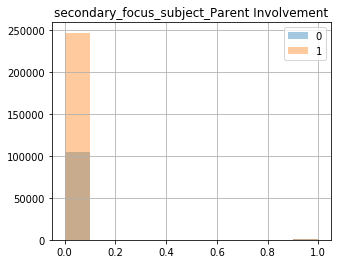

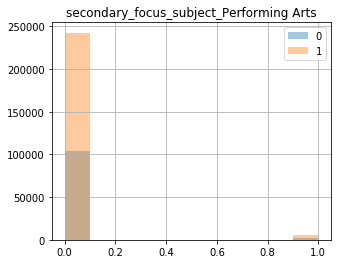

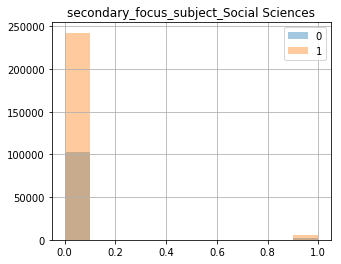

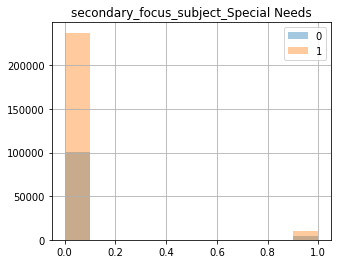

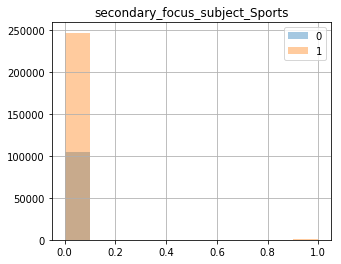

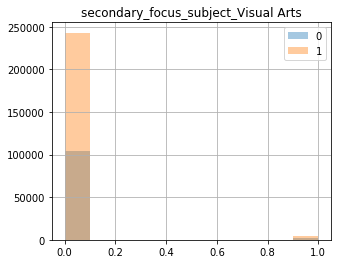

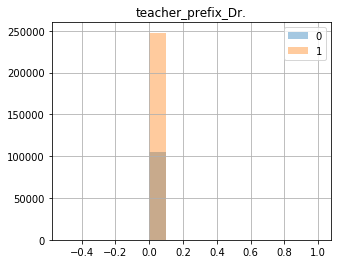

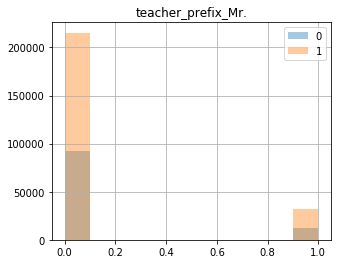

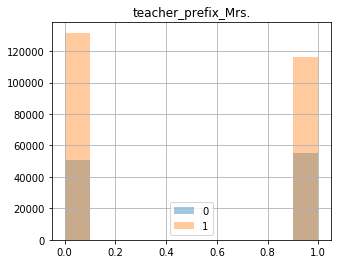

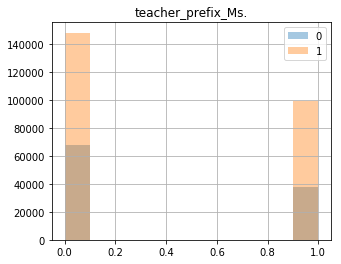

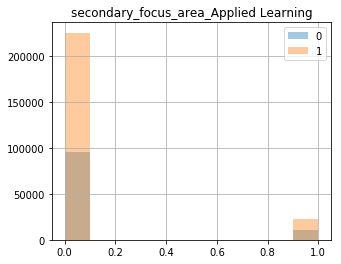

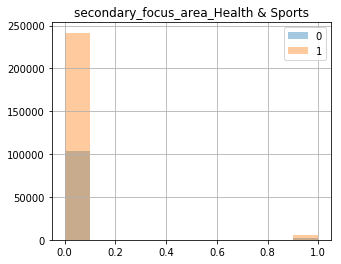

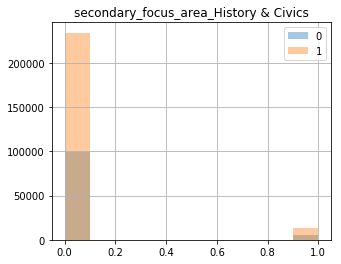

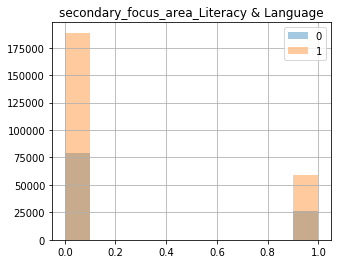

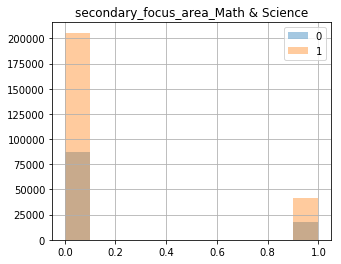

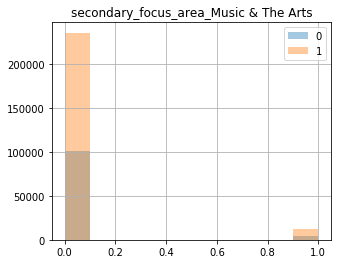

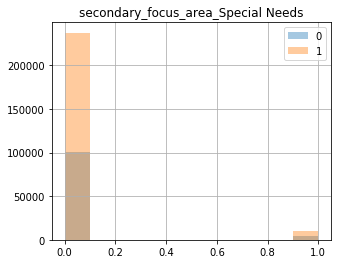

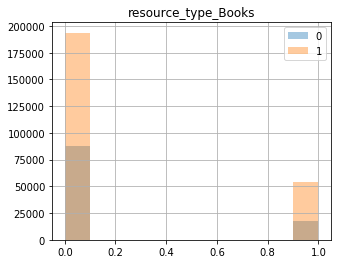

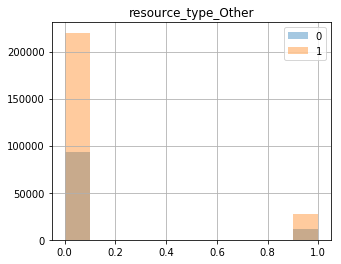

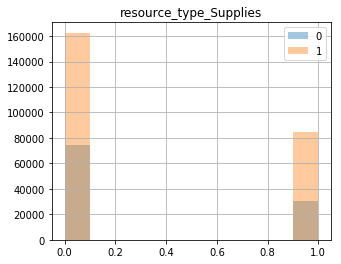

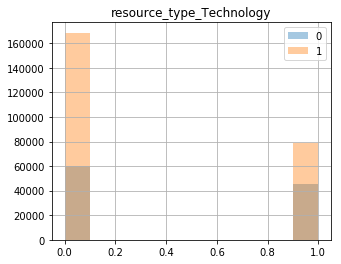

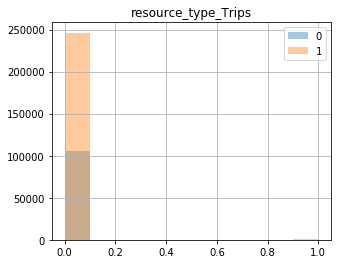

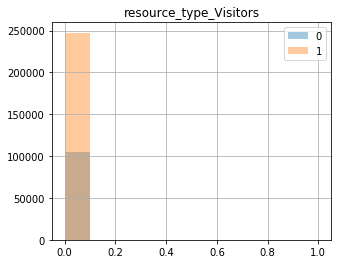

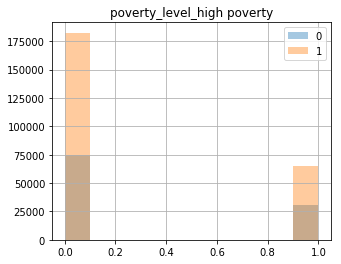

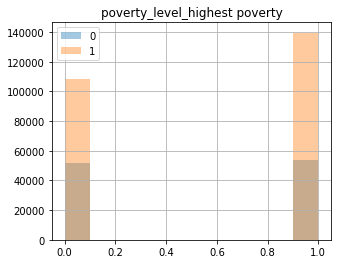

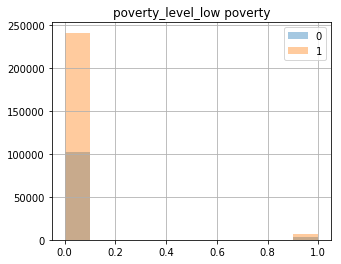

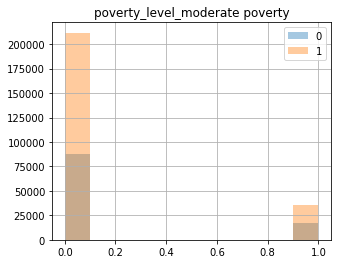

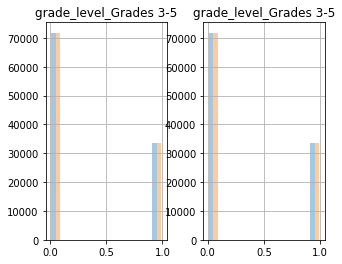

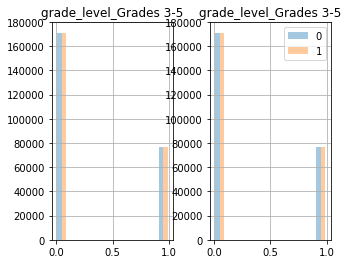

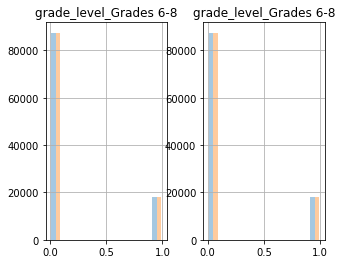

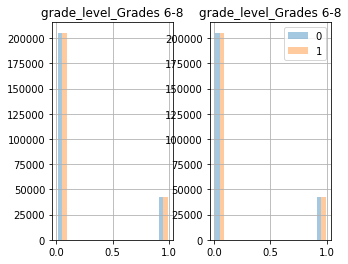

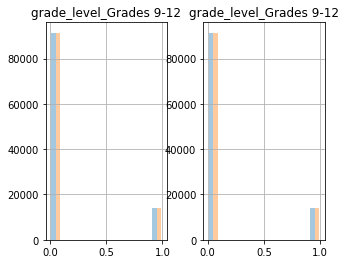

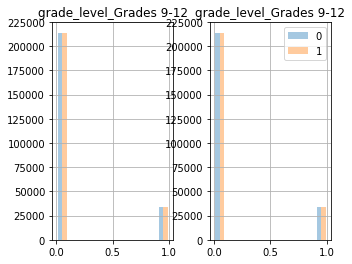

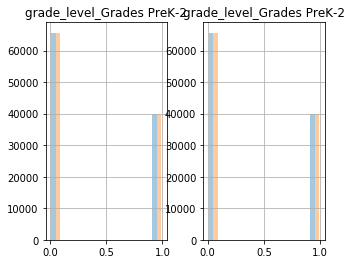

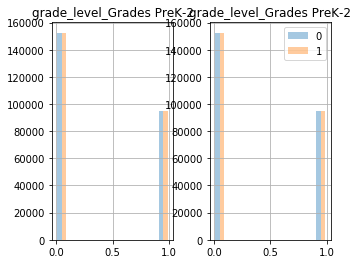

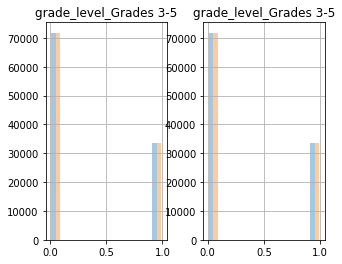

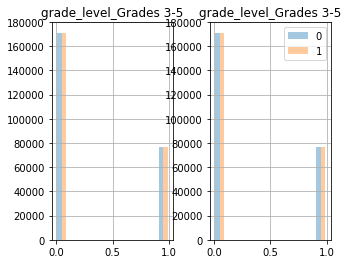

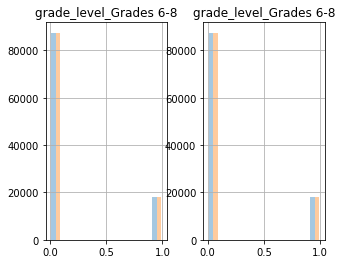

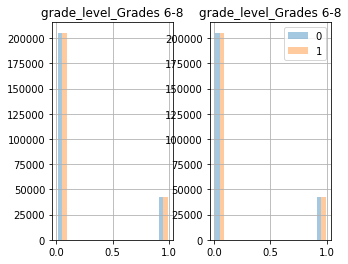

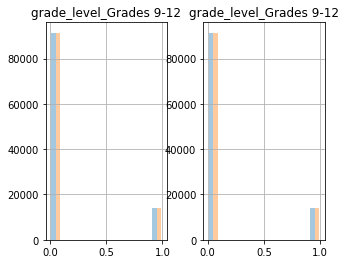

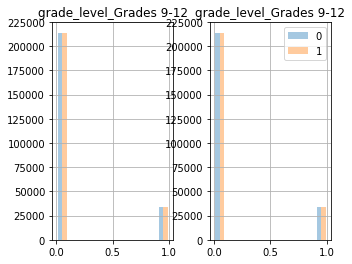

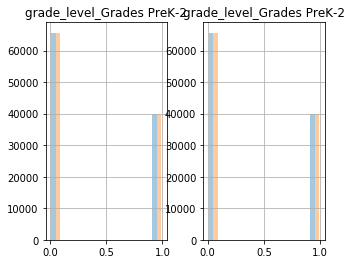

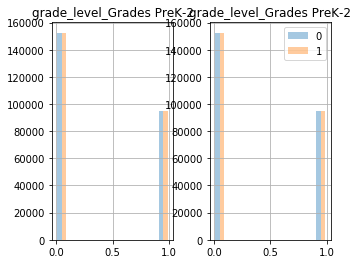

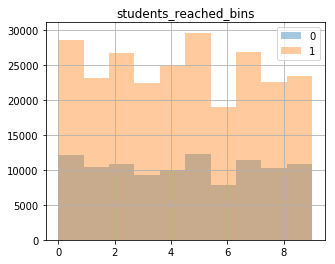

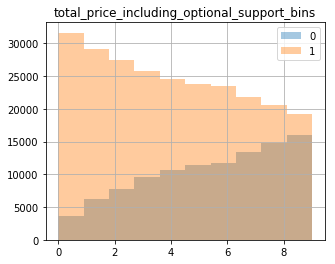

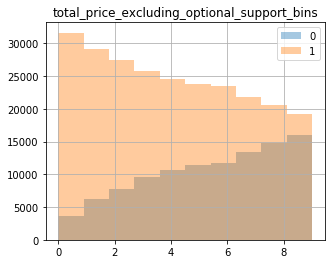

In [26]:
ex.plot_by_class(total_data, "fully_funded")

# Build and Evaluate Classifiers

I run the set of models on four temporal splits in 2011, increasing the training set by a 1-month increment each time, with the training set representing the subsequent month. Our temporal splits are as follows:

* Train: January 2011, Test: February 2011
* Train: January-February 2011, Test: March 2011
* Train: January-March 2011, Test: April 2011

This demonstrates the functionality of our temporal validation function, and the comparative performance of models given different-sized train and test sets. Because the full loop takes a significant amount of time to run, we constrain our time-series. To run the models on the full three-year time-series, we would change the end date in the temporal_validate function as well as the time wimdow if desired (see validation temporal splits below that use the full time-series and 6-month splits on a subset of classifiers).


In [26]:
temp_split = tm.temporal_validate('2011-01-01', '2011-4-30', [1])

In [27]:
temp_split

[[datetime.datetime(2011, 1, 1, 0, 0),
  datetime.datetime(2011, 1, 31, 0, 0),
  datetime.datetime(2011, 2, 1, 0, 0),
  datetime.datetime(2011, 2, 28, 0, 0),
  1],
 [datetime.datetime(2011, 1, 1, 0, 0),
  datetime.datetime(2011, 2, 28, 0, 0),
  datetime.datetime(2011, 3, 1, 0, 0),
  datetime.datetime(2011, 3, 31, 0, 0),
  1],
 [datetime.datetime(2011, 1, 1, 0, 0),
  datetime.datetime(2011, 3, 31, 0, 0),
  datetime.datetime(2011, 4, 1, 0, 0),
  datetime.datetime(2011, 4, 30, 0, 0),
  1]]

In [28]:
#Classifiers and test/full parameter sets for training and testing

classifiers = {'RF': RandomForestClassifier(n_estimators=50, n_jobs=-1),
    'LR': LogisticRegression(penalty='l1', C=1e5),
    'SVM': svm.SVC(kernel='linear', probability=True, random_state=0),
    'GB': GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=10),
    'DT': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(n_neighbors=3),
    'BG': BaggingClassifier(LogisticRegression(penalty='l1', C=1e5))
        }

parameters = { 
    'RF':{'n_estimators': [10,100], 'max_depth': [5, 20, 100], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10], 'n_jobs': [-1]},
    'LR': { 'penalty': ['l1','l2'], 'C': [0.001,0.1,1,10]},
    'GB': {'n_estimators': [10], 'learning_rate' : [0.1,0.5],'subsample' : [0.1,0.5], 'max_depth': [5]},
    'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [1,10,20,100],'min_samples_split': [2,5,10]},
    'SVM' :{'C' :[0.01],'kernel':['linear']},
    'KNN' :{'n_neighbors': [5,25],'weights': ['uniform','distance'],'algorithm': ['auto','ball_tree']},
    'BG': {'n_estimators' : [10, 20], 'max_samples' : [.25, .5]}
           }

test_grid = { 
    'RF':{'n_estimators': [1], 'max_depth': [1], 'max_features': ['sqrt'],'min_samples_split': [10]},
    'LR': { 'penalty': ['l1'], 'C': [0.01]},
    'GB': {'n_estimators': [1], 'learning_rate' : [0.1],'subsample' : [0.5], 'max_depth': [1]},
    'DT': {'criterion': ['gini'], 'max_depth': [1],'min_samples_split': [10]},
    'SVM' :{'C' :[0.01],'kernel':['linear']},
    'KNN' :{'n_neighbors': [5],'weights': ['uniform'],'algorithm': ['auto']},
     'BG': {'n_estimators' : [10], 'max_samples' : [.5]}
}
       

In [85]:
models_to_run = ['RF','DT','GB','SVM','KNN','LR','BG']

In [30]:
# train combinations of models, paramaters, and temporal splits
models, params = tm.run_models(models_to_run, classifiers, parameters, total_data, 'fully_funded', temp_split, 'date_posted')



Running through model RF...
Running through model DT...
Running through model GB...
Running through model SVM...
Running through model KNN...
Running through model LR...
Running through model BG...
Running through model RF...
Running through model DT...
Running through model GB...
Running through model SVM...
Running through model KNN...
Running through model LR...
Running through model BG...
Running through model RF...
Running through model DT...
Running through model GB...
Running through model SVM...
Running through model KNN...
Running through model LR...
Running through model BG...


In [31]:
models

,train_start,train_end,test_start,test_end,model_type,clf,parameters,auc-roc,p_at_1,p_at_2,p_at_5,p_at_10,p_at_20,p_at_30,p_at_50,r_at_1,r_at_2,r_at_5,r_at_10,r_at_20,r_at_30,r_at_50,f1_at_2,f1_at_20,f1_at_50
0,2011-01-01,2011-01-31,2011-02-01,2011-02-28,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.501059,0.952941,0.953216,0.904206,0.869312,0.836152,0.819984,0.777285,0.0148952,0.0299743,0.0711659,0.136999,0.2637,0.387826,0.612909,0.0581209,0.400951,0.685379
1,2011-01-01,2011-01-31,2011-02-01,2011-02-28,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.521929,0.964706,0.947368,0.92757,0.897316,0.862391,0.828927,0.788713,0.0150791,0.0297904,0.0730048,0.141412,0.271975,0.392056,0.62192,0.0577643,0.413533,0.695455
2,2011-01-01,2011-01-31,2011-02-01,2011-02-28,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.503921,0.929412,0.923977,0.908879,0.876313,0.844898,0.823095,0.787313,0.0145274,0.0290548,0.0715337,0.138102,0.266458,0.389298,0.620816,0.056338,0.405145,0.694222
3,2011-01-01,2011-01-31,2011-02-01,2011-02-28,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.508153,0.976471,0.964912,0.929907,0.891482,0.855977,0.829705,0.786381,0.015263,0.030342,0.0731887,0.140493,0.269952,0.392424,0.620081,0.058834,0.410457,0.693399
4,2011-01-01,2011-01-31,2011-02-01,2011-02-28,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'log2', 'min_...",0.504399,0.964706,0.929825,0.897196,0.883314,0.844315,0.820373,0.766325,0.0150791,0.0292387,0.0706142,0.139206,0.266274,0.38801,0.604266,0.0566946,0.404865,0.675715
5,2011-01-01,2011-01-31,2011-02-01,2011-02-28,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'log2', 'min_...",0.503467,0.976471,0.964912,0.918224,0.878646,0.857726,0.830871,0.78778,0.015263,0.030342,0.0722692,0.13847,0.270504,0.392975,0.621184,0.058834,0.411296,0.694633
6,2011-01-01,2011-01-31,2011-02-01,2011-02-28,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'log2', 'min_...",0.497721,0.988235,0.947368,0.918224,0.897316,0.853644,0.821928,0.785448,0.0154469,0.0297904,0.0722692,0.141412,0.269217,0.388746,0.619345,0.0577643,0.409339,0.692577
7,2011-01-01,2011-01-31,2011-02-01,2011-02-28,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'log2', 'min_...",0.504610,0.976471,0.964912,0.932243,0.898483,0.865306,0.837869,0.792444,0.015263,0.030342,0.0733726,0.141596,0.272894,0.396285,0.624862,0.058834,0.414931,0.698746
8,2011-01-01,2011-01-31,2011-02-01,2011-02-28,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 20, 'max_features': 'sqrt', 'min...",0.494715,0.882353,0.900585,0.883178,0.856476,0.834402,0.804044,0.766791,0.0137918,0.0283192,0.0695108,0.134976,0.263148,0.380287,0.604634,0.0549117,0.400112,0.676126
9,2011-01-01,2011-01-31,2011-02-01,2011-02-28,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 20, 'max_features': 'sqrt', 'min...",0.499854,0.941176,0.947368,0.922897,0.893816,0.861808,0.829316,0.787547,0.0147113,0.0297904,0.072637,0.140861,0.271791,0.39224,0.621,0.0577643,0.413253,0.694427


In [69]:
# identify model with maxumum auc-roc

models_nb = models[models['model_type'] != 'baseline']
models_nb.loc[models_nb['auc-roc'].idxmax()]

train_start                                  2011-01-01 00:00:00
train_end                                    2011-03-31 00:00:00
test_start                                   2011-04-01 00:00:00
test_end                                     2011-04-30 00:00:00
model_type                                                    RF
clf            (DecisionTreeClassifier(class_weight=None, cri...
parameters     {'max_depth': 20, 'max_features': 'log2', 'min...
auc-roc                                                 0.523255
p_at_1                                                  0.873684
p_at_2                                                  0.894737
p_at_5                                                  0.844211
p_at_10                                                 0.824395
p_at_20                                                 0.773922
p_at_30                                                 0.745882
p_at_50                                                 0.689655
r_at_1                   

In [42]:
params[161]

{'max_depth': 20,
 'max_features': 'log2',
 'min_samples_split': 10,
 'n_estimators': 100,
 'n_jobs': -1}

Reviewing the output table above, we see that none of the models performs particularly well in terms of overall accuracy, hovering at around .5 accuracy which does not exceed the baseline in any of our temporal splits. This suggests that there may be room for additional feature generation and model refinement. We also see that K-Nearest Neighbors, which is particularly sensitive to irrelevant features, performs poorly. This would suggest that the model could benefit from pruning some of the features and re-runnign the model. 

We also see that performance is fairly consistent across temporal splits, increasing slightly as the training set grows from one month to three months. This suggests that having more data in the training set yields a model that is less overfitted to the specific training data and thus performs better on the testing data. That said, several of the models perform very well on precision, with some maintaining near perfect precision up to 10%. The precision performs better than recall, which makes sense given the high prevalence of positive outcomes in our population - this suggests that our model may be over-classifying as negative which avoids false positives (preserving precision) but limiting both recall and accuracy.

The best performing model is the Random Forest on the train set of Jan-March and test set of April, with the following parameters {'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} with auc-roc = .523. 

We show the precision-recall curve for this best performing model below, noting that - due to the random nature of random forests - re-running the model is not guaranteed to produce the exact same results as in our initial loop, yet still gives an idea of the precision-recall tradeoff for this model.

In [43]:
# train best performing model and plot precision-recall curve
X_train, X_test, y_train, y_test = tm.temporal_split(total_data, temp_split[2][0], temp_split[2][1], temp_split[2][2], temp_split[2][3], 'date_posted', 'fully_funded')
X_train.students_reached_bins = X_train.students_reached_bins.fillna(X_train.students_reached_bins.median()) 
X_test.students_reached_bins = X_test.students_reached_bins.fillna(X_test.students_reached_bins.median()) 
rf= RandomForestClassifier(max_depth= 20, max_features= 'log2', min_samples_split= 10, n_estimators = 100, n_jobs= -1)
y_pred_probs = rf.fit(X_train, y_train).predict_proba(X_test)[:,1]


<Figure size 432x288 with 0 Axes>

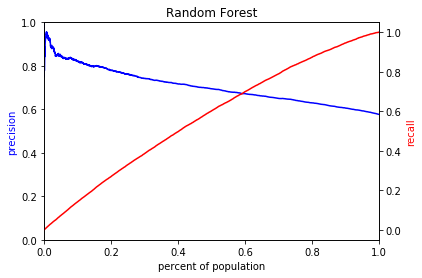

In [44]:
tm.plot_precision_recall_n(y_test, y_pred_probs, "Random Forest")

# Additional Analysis for Write-Up

In [25]:
#Produce 1-level decision tree as baseline
dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 1)

In [33]:
clf = dt.fit(X_train, y_train)
export_graphviz(clf, out_file='tree.dot') 

In [37]:
X_train.columns[117]

'total_price_including_optional_support_bins'

In [44]:
#Calculate proportion of fully funded projects per total_price_including_optional_support bin

total_data_price = total_data[['total_price_including_optional_support_bins', 'fully_funded']]

In [60]:
tp_gp = total_data_price.groupby('total_price_including_optional_support_bins').mean()

In [64]:
tp_gp.reset_index(inplace=True)


In [65]:
tp_gp.rename(index = str, columns ={'total_price_including_optional_support_bins':'total_price_bin'}, inplace = True)


In [66]:
tp_gp

,total_price_bin,fully_funded
0,0,0.895691
1,1,0.822275
2,2,0.780301
3,3,0.730421
4,4,0.697715
5,5,0.675594
6,6,0.666062
7,7,0.619360
8,8,0.581712
9,9,0.544726


In [76]:
# identify the most important features for the best-performing random forests model

fi = rf.feature_importances_
cols = X_train.columns

fi_names = pd.DataFrame({'feature_import' : fi,
 'cols' : cols
  }, columns=['feature_import','cols'])
fi_names.sort_values(by=['feature_import'], ascending = False)

,feature_import,cols
117,0.201741,total_price_including_optional_support_bins
118,0.184183,total_price_excluding_optional_support_bins
9,0.161894,eligible_double_your_impact_match
101,0.072011,resource_type_Technology
98,0.056136,resource_type_Books
5,0.029287,school_charter_ready_promise
105,0.027695,poverty_level_highest poverty
6,0.027472,teacher_teach_for_america
13,0.026907,school_metro_urban
10,0.022204,eligible_almost_home_match


In [50]:
total_data_top_10 = total_data[['eligible_double_your_impact_match', 'resource_type_Technology', 'resource_type_Books', 
                                'school_charter_ready_promise', 'poverty_level_highest poverty', 'teacher_teach_for_america',
                                'school_metro_urban', 'eligible_almost_home_match', 'fully_funded']]

In [51]:
top10_gp = total_data_top_10.groupby('fully_funded').mean()

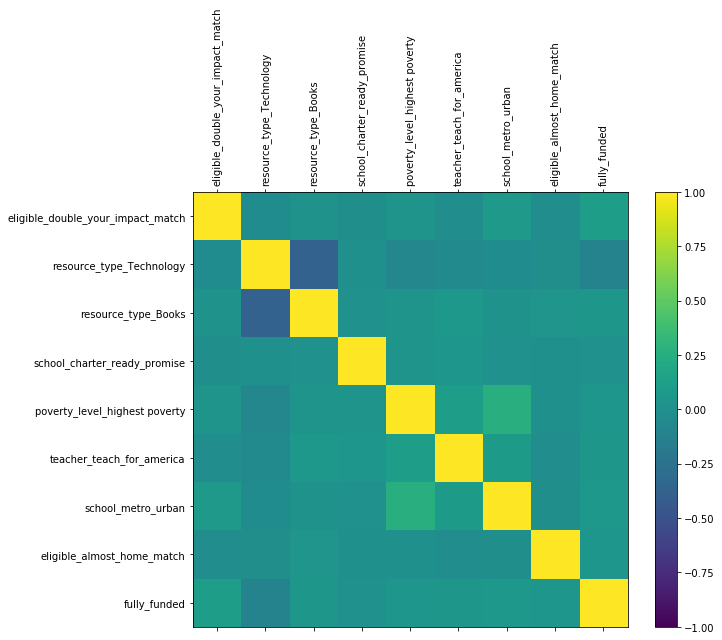

In [77]:
# correlation matrix for top 10 most important features
corr = ex.corr_table(total_data_top_10)
ex.plot_corr_matrix(corr)

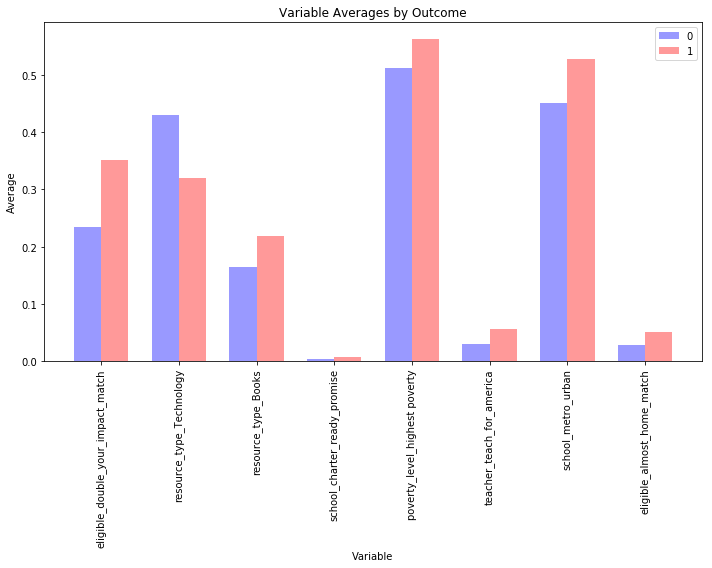

In [82]:
# plot variable averages by outcome for top 10 variables

em.var_avg_outcome_bin(top10_gp)

In [ ]:
# Group metrics by model type for largest temporal split

models_nb = models_nb[models_nb['test_start'] == '2011-04-01 00:00:00']
results_graph = models_nb[['model_type', 'auc-roc', 'p_at_10', 'r_at_10']]
results_graph[['p_at_10', 'r_at_10']] = results_graph[['p_at_10', 'r_at_10']].apply(pd.to_numeric)
rg_gp = results_graph.groupby('model_type').mean()
rg_gp.reset_index(inplace=True)

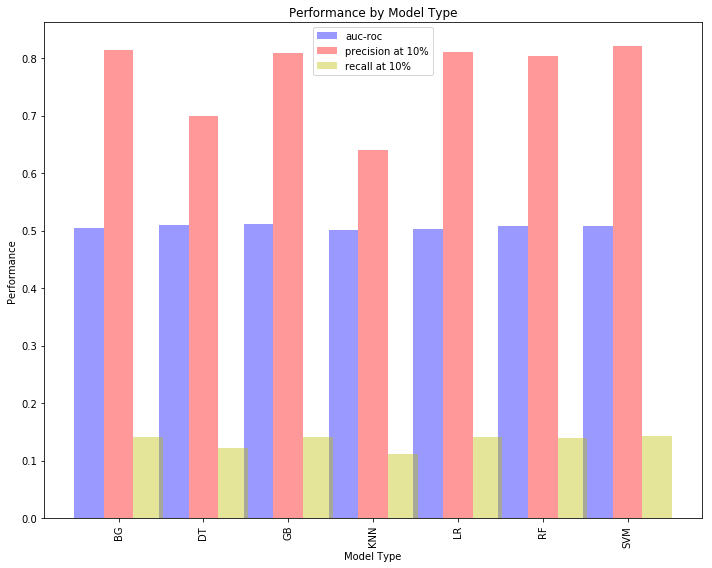

In [92]:
# Plot average performance by model type for auc-roc, precision at 10% and recall at 10%
em.perf_by_clf(rg_gp, models_to_run, ['auc-roc', 'p_at_10', 'r_at_10'], 'model_type')

In [64]:
# Check number of models run in loop above
len(models)

222

In [65]:
# Run validation loop on a subset of models on full time series and a larger temporal split of 6 months 
# to check findings above. RF and LR chosen because of strong performance and realively fast training times.

temp_split = tm.temporal_validate('2011-01-01', '2013-12-31', [6])

In [66]:
models_to_run2 = ['RF','LR']

In [67]:
models2, params2 = tm.run_models(models_to_run2, classifiers, parameters, total_data, 'fully_funded', temp_split, 'date_posted')

Running through model RF...
Running through model LR...
Running through model RF...
Running through model LR...
Running through model RF...
Running through model LR...
Running through model RF...
Running through model LR...
Running through model RF...
Running through model LR...


In [78]:
models2

,train_start,train_end,test_start,test_end,model_type,clf,parameters,auc-roc,p_at_1,p_at_2,p_at_5,p_at_10,p_at_20,p_at_30,p_at_50,r_at_1,r_at_2,r_at_5,r_at_10,r_at_20,r_at_30,r_at_50,f1_at_2,f1_at_20,f1_at_50
0,2011-01-01,2011-06-30,2011-07-01,2011-12-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.491973,0.945035,0.944149,0.927356,0.912296,0.891566,0.872903,0.838489,0.0127552,0.0254864,0.0626271,0.12322,0.24084,0.353699,0.566277,0.049633,0.379237,0.676008
1,2011-01-01,2011-06-30,2011-07-01,2011-12-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.495255,0.952128,0.951241,0.932318,0.91584,0.898122,0.874557,0.845115,0.0128509,0.0256778,0.0629622,0.123699,0.242611,0.354369,0.570752,0.0500058,0.382025,0.681351
2,2011-01-01,2011-06-30,2011-07-01,2011-12-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.489011,0.907801,0.903369,0.910702,0.899539,0.882353,0.866407,0.835725,0.0122526,0.0243856,0.0615024,0.121497,0.238352,0.351066,0.56441,0.0474892,0.375318,0.67378
3,2011-01-01,2011-06-30,2011-07-01,2011-12-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.499029,0.953901,0.948582,0.934798,0.919738,0.897502,0.878573,0.841891,0.0128748,0.025606,0.0631297,0.124225,0.242444,0.355996,0.568574,0.049866,0.381762,0.678751
4,2011-01-01,2011-06-30,2011-07-01,2011-12-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'log2', 'min_...",0.497259,0.943262,0.935284,0.922041,0.910524,0.891035,0.870718,0.828178,0.0127312,0.0252471,0.0622682,0.122981,0.240697,0.352813,0.559313,0.049167,0.379011,0.667695
5,2011-01-01,2011-06-30,2011-07-01,2011-12-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'log2', 'min_...",0.495329,0.953901,0.940603,0.930191,0.913359,0.895553,0.876919,0.839552,0.0128748,0.0253907,0.0628186,0.123364,0.241917,0.355326,0.566995,0.0494466,0.380933,0.676866
6,2011-01-01,2011-06-30,2011-07-01,2011-12-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'log2', 'min_...",0.498523,0.913121,0.925532,0.927356,0.910524,0.885542,0.867588,0.835796,0.0123244,0.0249838,0.0626271,0.122981,0.239213,0.351545,0.564458,0.0486543,0.376675,0.673837
7,2011-01-01,2011-06-30,2011-07-01,2011-12-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'log2', 'min_...",0.498967,0.953901,0.945922,0.924167,0.915131,0.89635,0.871899,0.840084,0.0128748,0.0255343,0.0624118,0.123603,0.242133,0.353292,0.567353,0.0497262,0.381272,0.677294
8,2011-01-01,2011-06-30,2011-07-01,2011-12-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 20, 'max_features': 'sqrt', 'min...",0.500274,0.941489,0.93883,0.927711,0.909639,0.882619,0.865226,0.833386,0.0127073,0.0253428,0.0626511,0.122861,0.238423,0.350588,0.562831,0.0493534,0.375431,0.671895
9,2011-01-01,2011-06-30,2011-07-01,2011-12-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 20, 'max_features': 'sqrt', 'min...",0.497656,0.948582,0.941489,0.926293,0.912651,0.894667,0.878632,0.845647,0.012803,0.0254146,0.0625553,0.123268,0.241678,0.35602,0.571111,0.0494932,0.380556,0.681779
